CódigraphTesto disponível [na minha página do Github](https://github.com/arthurkenzo/atividades_ia525)

### Importando bibliotecas

In [113]:
import cvxpy as cp
import numpy as np
import mosek
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import networkx as nx
import random


from typing import Tuple
from itertools import product


## Questão 1: Pintar o tabuleiro

Para obter o modelo, notamos primeiramente que, como as operações de inversão comutam entre si, o estado final de uma dada casa $(i,j)$ no tabuleiro depende somente do número total de inversões aplicadas em sua vizinhança (contando também a própria casa). Se esse número for ímpar, o estado da casa é invertido, senão seu estado não muda. Para saber o estado final de uma dada casa, precisamos então de uma variável que indique se o total de inversões em uma dada vizinhança é par ou ímpar. 

Isso pode ser feito considerando a representação binária do total de inversões: qualquer binário _par_ tem seu dígito menos significativo igual a $0$, assim como qualquer _ímpar_ tem seu dígito menos significativo igual a $1$. A partir dessa variável indicatriz, podemos definir condições para que uma dada casa $(i,j)$ seja preenchida ao final do jogo: se ela está inicialmente preenchida, precisamos aplicar um total _par_ de inversões em sua vizinhança, caso contrário precisamos de um número _ímpar_ de inversões. Em termos de lógica booleana, temos então a condição $m_{ij}\: \text{XOR}\: z_{ij}^{(0)}$, onde $m_{ij}$ é o valor inicial da casa e $z_{ij}^{(0)}$ é o dígito menos significativo da representação binária do total de inversões aplicadas.

Um jogo é então _factível_ se essa condição é respeitada para todas as casas do tabuleiro. O jogo _ótimo_ será dado pelo jogo factível com menor número de inversões aplicadas no tabuleiro todo. Chegamos então ao seguinte modelo:

### Modelo:

\begin{align*}
    \text{Minimizar }   & x_{ij}\\
    \text{sujeito a }   & \sum_{i'j'\in N(i,j)} x_{ij} = 4z_{ij}^{(4)} + 2z_{ij}^{(2)} + z_{ij}^{(1)} \quad \forall  i,j  \hspace{20pt} \text{(Codificação binária do total de inversões aplicadas)} \\
                        & m_{ij} + z_{ij}^{(0)} = 1 \quad \forall  i,j  \hspace{20pt} \text{(Inversões necessárias para deixar a casa pintada)} \\
                        & x_{ij}, z_{ij}^{(n)} \in \mathbb{B} \quad \forall i,j,n \hspace{20pt} \text{(Variáveis de decisão binárias)} \\ 
\end{align*}

Neste modelo, $x_{ij}$ denota variáveis de decisão tais que $x_{ij} = 1$ $\iff$ uma inversão é aplicada à célula $(i,j)$ e as células adjacentes, $N(i,j)$ denota o conjunto de células afetadas por uma operação de inversão em $(i,j)$, $z_{ij}^{(n)}$ é o $n$-ésimo dígito da codificação binária do número total de inversões na vizinhança de cada célula. O estado inicial do tabuleiro é dado por $m_{ij}$, onde $m(i,j)=1$ $\iff$ a célula está inicialmente preenchida. 

In [114]:
def SolvePintarTabuleiro(board:np.ndarray) -> np.ndarray:
    """ Solves the Pintar o Tabuleiro game using linear programming. Returns the locations of the cell flips from the solution with minimal flips.

    Args:
        board (np.ndarray): Inital board state.

    Returns:
        np.ndarray: Array with cell values =1 when a flip must be made at the cell, and zero if not. 
    """

    boardShape = board.shape

    # defining decision and auxiliary variables
    flipVars = cp.Variable(boardShape, boolean=True, name="flip")
    encodingVars1 = cp.Variable(boardShape, boolean=True, name="encode0")
    encodingVars2 = cp.Variable(boardShape, boolean=True, name="encode2")
    encodingVars4 = cp.Variable(boardShape, boolean=True, name="encode4")

    # constraints
    constraints = []

    # encoding the number of incident flips onto binary variables
    for i in range(boardShape[0]):
        for j in range(boardShape[1]):

            expression = flipVars[i, j]  # start with the cell itself
            if i > 0:
                expression += flipVars[i - 1, j]  # up
            if i < boardShape[0] - 1:
                expression += flipVars[i + 1, j]  # down
            if j > 0:
                expression += flipVars[i, j - 1]  # left
            if j < boardShape[1] - 1:
                expression += flipVars[i, j + 1]  # right

            # Example: no more than 2 adjacent ON cells including itself
            constraints.append(expression == 4*encodingVars4[i,j] + 2*encodingVars2[i,j] + encodingVars1[i,j])

    # flip codition: if total number of incident flips is odd, cell is flipped 
    for i in range(boardShape[0]):
        for j in range(boardShape[1]):
            constraints += [board[i,j] + encodingVars1[i,j] == 1]


    # minimizing total number of flips on the board
    objective = cp.Minimize(cp.sum(flipVars))

    # solving
    lp = cp.Problem(objective, constraints)
    lp.solve(solver="MOSEK", verbose=False)

    return flipVars.value.round(1)

In [115]:
def main():
    # dado de entrada - matriz do tabuleiro
    M = np.array([[1,0,1,1,1],[1,0,1,0,1],[0,0,1,0,0],[1,0,0,1,1],[0,1,0,1,0],[1,1,0,1,1]])
    
    ### implementação do CVXPY --- tarefa
    X = SolvePintarTabuleiro(M)
    print("Número de jogadas: ", np.sum(X))

    # resposta obtida pelo CVXPY    
    # X = np.array([[1,0,1,0,0],[1,1,1,1,0],[1,0,0,1,1],[1,1,0,0,1],[1,1,0,0,0],[0,1,0,0,0]])
    # print("Número de jogadas: ", np.sum(X))
    
    # "interface gráfica" para observar as jogadas realizadas
    tabuleiroResolvido = tabuleiro(X,M)

    if np.sum(tabuleiroResolvido) == M.shape[0]*M.shape[1]:
        print("Tabuleiro resolvido com sucesso")
    else:
        print("Tabuleiro não foi resolvido.")


def imprimir(_M,jogada) :
    [m,n] = _M.shape
    #C = colormap([1 1 1; 0 0 0; 0 1 0]
    fig, ax = plt.subplots()
    i = ax.imshow(_M, interpolation='nearest', cmap=cm.BuPu, vmin=0, vmax=2)
    #fig.colorbar(i)
    print("Jogada ",str(jogada)) 
    plt.show()

def inverter(val) :
    if val == 0 :
        return 1
    if val == 1 :
        return  0

def tabuleiro(_X,_M) :
    [m,n] = _M.shape
    iv = np.arange(0,m)
    random.shuffle(iv)
    jv = np.arange(0,n)
    random.shuffle(jv) 
    jogada=0
    for i in iv  :
        for j in jv :
            if _X[i,j] == 1 :      
                jogada = jogada + 1                    
                _M[i,j] = _M[i,j] + 2
                # imprimir(_M,jogada) 
                if i > 0 :
                    _M[i-1,j] = inverter(_M[i-1,j])
                if i < m-1 :
                    _M[i+1,j] = inverter(_M[i+1,j])
                if j > 0 :
                    _M[i,j-1] = inverter(_M[i,j-1])
                if j < n-1 :                
                    _M[i,j+1] = inverter(_M[i,j+1])
                _M[i,j] = _M[i,j] - 2
                _M[i,j] = inverter(_M[i,j])          
                # imprimir(_M,jogada)   
 
    return _M   

main()

Número de jogadas:  15.0
Tabuleiro resolvido com sucesso


## Questão 2: Sudoku

### Modelo:

\begin{align*}
    \text{Encontrar }   & ijk x_{ijk}\\
    \text{sujeito a }   & \sum_{k} x_{ijk} = 1 \quad \forall  i,j  \hspace{20pt} \text{(Alocar apenas um número a cada casa)} \\
                        & \sum_{i} x_{ijk} = 1 \quad \forall  j,k  \hspace{20pt} \text{(Unicidade de cada número em cada coluna)} \\
                        & \sum_{j} x_{ijk} = 1 \quad \forall  i,k  \hspace{20pt} \text{(Unicidade de cada número em cada linha)} \\
                        & \sum_{p,p',q,q'} x_{(3p+q),(3p'+q'),k} = 1 \quad \forall  k;  \quad p,p',q,q' \in \{0,1,2\} \hspace{20pt} \text{(Unicidade de cada número em cada submatriz)} \\
                        & x_{ijk} = 1 \quad \forall i,j,k: \: \text{board}(i,j) = k \hspace{20pt} \text{(Fixar valores do tabuleiro inicial)}\\
                        & x_{ijk}\in \mathbb{B} \quad \forall  i,j,k  \hspace{20pt} \text{(Variáveis de decisão binárias)} \\
\end{align*}

onde os índices $(i,j,k)$ que indexam as variáveis são números interios no intervalo $[0,8]$, e as variáveis de decisão $x_{ijk} \in \mathbb{B}$ são não nulas $\iff$ $k$ for o número escolhido para a casa $(i,j)$ do tabuleiro.  Assumimos que o tabuleiro inicial é dado por uma matriz $\text{board}$ cujas casas vazias são preenchidas com zero.

Como o problema pode ser altamente degenerado (por se tratar de um problema de factibilidade), poderíamos definir um ordenamento arbitrário das soluções através da função objetivo. Neste caso no entanto, isso não se mostrou necessário devido ao tamanho reduzido do problema. 

In [116]:
def SolveSudoku(board:np.ndarray) -> np.ndarray:
    """ Solves a sudoku board by building and solving a linear program. 

    Args:
        board (np.ndarray): An array with the initial board values. Empty cells are assumed to be zero-valued.

    Returns:
        np.ndarray: A 3d array containing the optimal values of the model's binary decision variables.
    """

    boardSize = len(board[:,0])
    submatrixSize = 3
    digits = range(boardSize)
    submatrices = range(submatrixSize)

    # decision variables
    decisionVars = np.empty((boardSize, boardSize, boardSize), dtype=object)
    for i in digits:
        for j in digits:
            for k in digits:
                decisionVars[i,j,k] = cp.Variable(boolean=True, name=f"x_{i}{j}{k}")

    # constraints
    constraints = []
    # one single value per cell
    for i in digits:
        for j in digits:
            constraints += [np.sum(decisionVars[i,j,:]) == 1]

    # uniqueness in every column
    for j in digits:
        for k in digits:
            constraints += [np.sum(decisionVars[:,j,k]) == 1]
    
    # uniqueness in every row
    for i in digits:
        for k in digits:
            constraints += [np.sum(decisionVars[i,:,k]) == 1]

    # uniqueness in every sub-matrix
    for k in digits:
        for blockRow in submatrices:
            for blockCol in submatrices:
                constraint_expr = cp.sum([decisionVars[3*blockRow + i, 3*blockCol + j, k]
                                        for i in submatrices
                                        for j in submatrices])
                constraints.append(constraint_expr == 1)

    # initial board values 
    for i in digits:
        for j in digits:
            boardValue = board[i,j]
            if boardValue != 0:
                constraints.append(decisionVars[i, j, board[i,j] - 1] == 1)

    objective = cp.Minimize(0)

    lp = cp.Problem(objective, constraints)
    lp.solve(solver="MOSEK", verbose=False)

    return decisionVars

def DecodeSolution(decisionVars:np.ndarray) -> np.ndarray:
    """ From a 3d array with binary variables representing a possible solution, build the corresponding 2d board.

    Args:
        decisionVars (np.ndarray): Binary decision variables representing a possible solution to a sudoku board.

    Returns:
        np.ndarray: Reconstructed sudoku board.
    """

    boardSize = len(decisionVars[0,:,:])
    digits = range(boardSize)

    solution = np.zeros((boardSize, boardSize), dtype=int)
    for i in digits:
        for j in digits:
            for k in digits:
                if decisionVars[i, j, k].value > 0.5:
                    solution[i, j] = k + 1
                    break
                
    return solution

def CheckSudoku(board):
    # Check if all rows contain digits 1-9 without duplicates
    for row in board:
        if not isValidGroup(row):
            return False

    # Check if all columns contain digits 1-9 without duplicates
    for col in range(9):
        column = [board[row][col] for row in range(9)]
        if not isValidGroup(column):
            return False

    # Check each 3x3 sub-box
    for box_row in range(3):
        for box_col in range(3):
            block = []
            for r in range(box_row * 3, box_row * 3 + 3):
                for c in range(box_col * 3, box_col * 3 + 3):
                    block.append(board[r][c])
            if not isValidGroup(block):
                return False

    return True

def isValidGroup(nums):
    # Check if the group contains digits 1-9 exactly once
    nums = [n for n in nums if n != 0]  # Ignore zeros if you want to allow incomplete boards
    return len(nums) == 9 and set(nums) == set(range(1, 10))

In [117]:
board = np.array([
    [0, 0, 0, 0, 0, 3, 0, 8, 5],
    [0, 0, 1, 0, 2, 0, 0, 0, 0],
    [0, 0, 0, 7, 0, 1, 3, 0, 0],
    [0, 0, 3, 0, 0, 0, 0, 1, 0],
    [9, 0, 0, 0, 0, 0, 0, 0, 4],
    [0, 5, 0, 0, 0, 0, 6, 0, 0],
    [0, 0, 7, 3, 0, 8, 0, 0, 0],
    [0, 0, 0, 0, 6, 0, 4, 0, 0],
    [3, 9, 0, 4, 0, 0, 0, 0, 0]
]
)
print("Initial Sudoku board: ")
print(board)
print("")
solution = SolveSudoku(board)

solution = DecodeSolution(solution)
print("Solved Sudoku board: ")
print(solution)
print("")
print("Is the board correctly filled: ", CheckSudoku(solution))

Initial Sudoku board: 
[[0 0 0 0 0 3 0 8 5]
 [0 0 1 0 2 0 0 0 0]
 [0 0 0 7 0 1 3 0 0]
 [0 0 3 0 0 0 0 1 0]
 [9 0 0 0 0 0 0 0 4]
 [0 5 0 0 0 0 6 0 0]
 [0 0 7 3 0 8 0 0 0]
 [0 0 0 0 6 0 4 0 0]
 [3 9 0 4 0 0 0 0 0]]

Solved Sudoku board: 
[[7 4 2 6 9 3 1 8 5]
 [6 3 1 8 2 5 7 4 9]
 [5 8 9 7 4 1 3 6 2]
 [2 6 3 5 7 4 9 1 8]
 [9 7 8 1 3 6 2 5 4]
 [1 5 4 9 8 2 6 7 3]
 [4 2 7 3 1 8 5 9 6]
 [8 1 5 2 6 9 4 3 7]
 [3 9 6 4 5 7 8 2 1]]

Is the board correctly filled:  True


## Questão 3: Senha

A factibilidade deste problema dependerá do número e qualidade das dicas dadas pelo detentor do código. Caso sejam dadas menos dicas do que o necessário, teremos mais de uma solução possível para o problema de factibilidade (podemos fazer um paralelo com um sistema linear com mais variáveis do que equações). No caso de dicas conflitantes, teremos um problema não factível (no paralelo com sistemas lineares, temos duas equações conflitantes entre si). É ainda possível que duas dicas deem informações equivalentes, como no caso de duas equações linearmente dependentes. 

O jogo pode ser modelado por meio da resolução iterativa de um programa linear de factibilidade. Na primeira rodada, temos penas as restrições de integralidade e de alocação de um único dígito em cada local. Isso, junto com uma função objetivo com coeficientes aleatórios, gera um chute que será usado para definir possíveis dicas para a próxima rodada. 

Decidimos modelar dois tipos possíveis de dicas: se $n$ dígitos foram corretamente alocados nos locais corretos, e se $n$ dígitos foram escolhidos corretamente, ao menos um deles não foi alocado no local correto. Cada uma delas corresponde a um conjunto de restrições que é adicionado ao modelo a cada iteração. Como resultado, o número total de restrições do modelo aumenta de forma não decrescente, sempre reduzindo ou deixando inalterado o conjunto factível do problema. Após iterações o suficiente espera-se que ou o solver gre um chute aleatório correspondente à senha, ou que o conjunto factível se restrinja à solução correta, forçando o solver a gerar a senha.

### Modelo:

\begin{align*}
    \text{Encontrar }   & \sum_{\substack{i\in N \\ j\in M}}r_{ij}x_{ij}\\
    \text{sujeito a }   & \sum_{i}x_{ij} = 1,\, \forall j \in  M \hspace{20pt} \text{(Alocar um único dígito em cada local)} \\
                        & \sum_{(i,j)\in C}x_{ij} = n \hspace{20pt} \text{(Opcional: n dígitos corretos nos locais corretos)} \\
                        & \sum_{\substack{(i,.)\in C \\ j\in M}} x_{ij} >= n \hspace{20pt} \text{(Opcional: n dígitos corretos no local errado)} \\
                        & x_{ij} = \mathbb{B} \quad \forall i\in N,\, \forall j\in M:  \hspace{20pt} \text{(Variáveis de decisão binárias)} \\
\end{align*}

Onde $N$ é o conjunto de possíveis símbolos para a senha, $M$ o conjunto de dígitos da senha, e $C$ o conjunto de pares dígito-local que definem o último chute dado pelo jogador. As variáveis $r_{ij}$ valores aleatórios amostrados de uma distribuição uniforme no intervalo $[0,1]$ a cada nova iteração - isso permite ao solver gerar um chute diferente a cada rodada, mesmo se as restrições não mudarem.

In [118]:
def interpretPasswordSolution(solution:np.ndarray) -> str:
    """ Returns the password in string format from a solution of the integer programming formulation to the password problem.

    Args:
        solution (np.ndarray): Binary array with the values of a feasible solution to the password problem, as per our modeling. 

    Returns:
        str: A password in string format.
    """

    guess = ""

    for i in range(len(solution[:,0])):
        for j in range(len(solution[0,:])):
            if solution[i,j] == 1:
                guess += f"{i}"

    return guess

In [119]:
# problem parameters
password = "789"
digits = 10
maxGuesses = 50
wrongPassword = True
infeasibleModel = False
lastGuess = "000"

M = list(range(len(password)))
N = list(range(digits))


iters = 0
while wrongPassword and iters<maxGuesses:    
    iters += 1
    print("-------------------------")
    print("Current iteration: ", iters)

    # only instantiate new decision variables and constraint sets at the beggining of the game
    # the single digit at each spot constraint needs only be added once to the model, at the beggining
    if iters == 1:

        # decision variables
        decisionVars = cp.Variable((digits, len(password)), boolean=True, name="digitos")

        # constraints
        constraints = []
        # one single value per spot
        for j in M:
            constraints += [cp.sum(decisionVars[:,j]) == 1]
    
    print(f"Chute anterior: {lastGuess}")
    # check if any number is in the correct spot
    correctSpots = []
    for i in range(len(lastGuess)):
        if lastGuess[i] == password[i]:
            correctSpots += [i]

    # check if any number is in the password but maybe not in the right spot
    correctDigits = []
    for i in range(len(lastGuess)):
        if lastGuess[i] in password:
            correctDigits += [lastGuess[i]]


    # linear expression for the inequality constraints
    expression = 0

    # decide which set of costraints will be added to the model based on the previous guess
    # priority is given to correct digits in correct spots

    # n correct digits, correct spots
    if correctSpots: 
        print(f"Você chutou {len(correctSpots)} dígitos no local correto.")
        for j, i in enumerate(lastGuess):
            i = int(i)
            expression += decisionVars[i, j]
        
        constraints += [expression >= len(correctSpots)]
 
    # n correct digits, maybe wrong spots
    elif correctDigits:
        print(f"{len(correctDigits)} dígitos do seu chute estão na senha, mas ao menos um não está no local correto.")
        for j in M:
            for i in lastGuess:
                i = int(i)
                expression += decisionVars[i, j]
    
        constraints += [expression >= len(correctDigits)]
    else:
        print(f"Nenhum dígito do seu chute está correto.")
            
    # builds random objective in order to generate a guess for the password
    randomCoeffs = np.random.rand(digits, len(password)) 
    objective = cp.Minimize(cp.sum(cp.multiply(randomCoeffs, decisionVars)))

    # printing the linear program to check if constraints are being added correctly
    lp = cp.Problem(objective, constraints)
    # print("")
    # print(lp)
    # print("")

    # solving problem and checking if model is still feasible
    lp.solve(solver="MOSEK", verbose=False)

    if lp.status != cp.OPTIMAL:
        print("Problem is unfeasible")
        infeasibleModel = True
        break
    
    # interpret the solver's result as a password string and check if it is correct
    lastGuess = interpretPasswordSolution(np.round(decisionVars.value))

    if lastGuess == password:
        wrongPassword = False

    print(f"Novo chute: {lastGuess}")

if not wrongPassword:
    print("=======================")
    print(f"Encontramos a senha correta! A senha é {lastGuess} e foi encontrada em {iters} iterações.")
elif infeasibleModel:
    print("=======================")
    print(f"O modelo se tornou infactível.")
else:
    print("=======================")
    print(f"Chegamos no limite máximo de {maxGuesses} iterações sem achar a senha correta.")

    

-------------------------
Current iteration:  1
Chute anterior: 000
Nenhum dígito do seu chute está correto.
Novo chute: 223
-------------------------
Current iteration:  2
Chute anterior: 223
Nenhum dígito do seu chute está correto.
Novo chute: 222
-------------------------
Current iteration:  3
Chute anterior: 222
Nenhum dígito do seu chute está correto.
Novo chute: 022
-------------------------
Current iteration:  4
Chute anterior: 022
Nenhum dígito do seu chute está correto.
Novo chute: 266
-------------------------
Current iteration:  5
Chute anterior: 266
Nenhum dígito do seu chute está correto.
Novo chute: 115
-------------------------
Current iteration:  6
Chute anterior: 115
Nenhum dígito do seu chute está correto.
Novo chute: 446
-------------------------
Current iteration:  7
Chute anterior: 446
Nenhum dígito do seu chute está correto.
Novo chute: 134
-------------------------
Current iteration:  8
Chute anterior: 134
Nenhum dígito do seu chute está correto.
Novo chute: 779


## Questão 4: Oito rainhas

### Modelo:

\begin{align*}
    \text{Minimizar }   & ij x_{ij}\\
    \text{sujeito a }   & \sum_{ij} x_{ij} <= 1 \quad  \hspace{20pt} \text{(Total de oito rainhas no tabuleiro)} \\
                        & \sum_{i} x_{ij} <= 1 \quad \forall  j  \hspace{20pt} \text{(No máximo uma rainha por coluna)} \\
                        & \sum_{j} x_{ij} <= 1 \quad \forall  i  \hspace{20pt} \text{(No máximo uma rainha por linha)} \\
                        & \sum_{kl} x_{kl} <= 1 \quad \forall  (k,l) \in \text{diag}(i,j)  \hspace{20pt} \text{(No máximo uma rainha por diagonal principal)} \\
                        & \sum_{kl} x_{kl} <= 1 \quad \forall  (k,l) \in \text{antidiag}(i,j)  \hspace{20pt} \text{(No máximo uma rainha por diagonal secundária)} \\
                        & x_{ij} = 1 \quad \forall i,j: \: \text{board}(i,j) = 1 \hspace{20pt} \text{(Fixar valores do tabuleiro inicial)}\\
                        & x_{ij}\in \mathbb{B} \quad \forall  i,j  \hspace{20pt} \text{(Variáveis de decisão binárias)} \\
\end{align*}

As variáveis de decisão binárias $x{ij}$ denotam a presença de uma rainha na pasição $(i,j)$ do tabuleiro. As posições iniciais de rainhas, se existirem, são dadas pelos elementos de $\text{board}$ iguais a $1$. Assim como no caso do Sudoku, temos um problema de factibilidade, e portanto definimos uma função objetivo arbitrária para reduzir as degenerecências das soluções do problema. 

In [120]:
def SolveEightQueens(board:np.ndarray) -> np.ndarray:

    boardShape = board.shape
    boardSize = len(board[:,0])
    submatrixSize = 3
    cells = range(boardSize)
    submatrices = range(submatrixSize)

    # decision variables
    decisionVars = cp.Variable(boardShape, boolean=True, name="placeQueen")

    # constraints
    constraints = []


    # total of 8 queens in the board
    constraints += [cp.sum(decisionVars) == 8]

    # at most one single queen per row
    for j in cells:
        constraints += [cp.sum(decisionVars[:,j]) <= 1]

    # at most one single queen per column
    for i in cells:
        constraints += [cp.sum(decisionVars[i,:]) <= 1]

    # at most one single queen per diagonal
    for d in range(-(boardSize - 1), boardSize):
        diagCells = [decisionVars[i, j] for i in cells for j in cells if i - j == d]
        if diagCells:
            constraints += [cp.sum(diagCells) <= 1]

    # at most one single queen per anti-diagonal
    for d in range(2*boardSize - 1):
        antiDiagCells = [decisionVars[i, j] for i in cells for j in cells if i + j == d]
        if antiDiagCells:
            constraints += [cp.sum(antiDiagCells) <= 1]

    # initial queen positions
    rows, columns = np.where(board == 1)
    initialPositions = list(zip(rows, columns))
    for (i,j) in initialPositions:
        constraints += [decisionVars[i,j] == 1]

    # building arbitrary objective function
    objective = cp.Minimize(0)

    lp = cp.Problem(objective, constraints)
    lp.solve(solver="MOSEK", verbose=False)

    return decisionVars


In [121]:
boardSize = 8

board = np.zeros((boardSize, boardSize))

solution = SolveEightQueens(board)
solution.value.round(3)

array([[ 0.,  0.,  0.,  1.,  0.,  0., -0.,  0.],
       [-0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0., -0.,  1.,  0., -0.,  0.],
       [ 0.,  1., -0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0., -0., -0.,  0.,  0.],
       [ 0.,  0.,  1., -0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -0.,  0.,  0.,  1.]])

Jogada 0


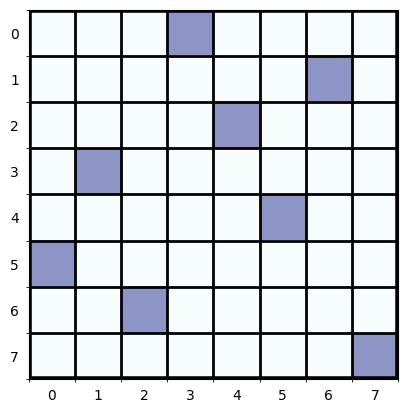

In [122]:
import matplotlib.patches as patches

# código da plotagem do problema de pintr o tabuleiro modificado para o problema das oito rainhas
def imprimir(_M, jogada):
    m, n = _M.shape
    
    fig, ax = plt.subplots()
    cax = ax.imshow(_M, interpolation='nearest', cmap=cm.BuPu, vmin=0, vmax=2)

    # Inner gridlines
    ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, m, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    
    ax.tick_params(left=False, bottom=False)
    
    # Draw thick outer rectangle
    rect = patches.Rectangle(
        (-0.5, -0.5), n, m,  # position and size
        linewidth=4,         # thickness of outer border
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(rect)

    print("Jogada", jogada)
    plt.show()

imprimir(solution.value.round(3), 0)